# Improving classification with the AdaBoost meta-algorithm

$\epsilon = \frac{number of incorrectly classified examples}{total number of examples}$

$\alpha = \frac{1}{2}\ln (\frac{1-\epsilon}{\epsilon})$

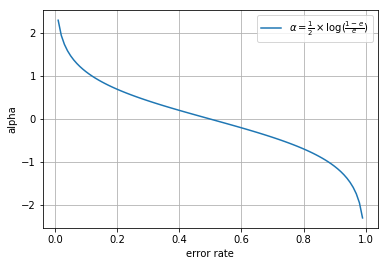

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

e = np.arange(0.01,1,0.01)
alpha = 1/2*np.log((1-e)/e)
plt.figure()
plt.plot(e,alpha,label='$\\alpha =\\frac{1}{2}\\times\\log(\\frac{1-e}{e})$')
plt.xlabel('error rate')
plt.ylabel('alpha')
plt.grid()
plt.legend()
plt.show()

if correctly predicted:
$$D_i^{(t+1)} = \frac{D_i^{(t)}e^{-\alpha}}{Sum(D)}$$
if incorrectly predicted:
$$D_i^{(t+1)} = \frac{D_i^{(t)}e^{\alpha}}{Sum(D)}$$

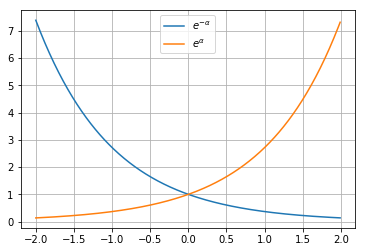

In [3]:
alpha = np.arange(-2,+2,0.01)
plt.figure()
plt.plot(alpha, np.exp(-alpha),label='$e^{-\\alpha}$')
plt.plot(alpha, np.exp(alpha),label='$e^{\\alpha}$')
plt.legend()
plt.grid()
plt.show()

In [4]:
import numpy as np
def loadSimData():
    datMat = np.matrix([
        [1.,2.1],
        [2.,1.1],
        [1.3,1.],
        [1.,1.],
        [2.,1.]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat, classLabels

[1.  2.  1.3 1.  2. ]


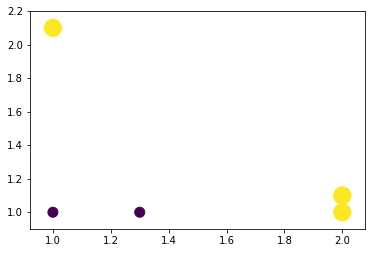

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

dataMat,classLabels = loadSimData()
print(dataMat[:,0].flatten().getA()[0])
fig=plt.figure()
ax = fig.add_subplot(111)
ax.scatter(dataMat[:,0].flatten().getA()[0],dataMat[:,1].flatten().getA()[0],(np.array(classLabels)+2)*100,(np.array(classLabels)+2)*50)
plt.show()

In [6]:
# perform a threshold comarison to classify data
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):
    # set the return array to all 1s
    retArray = np.ones((np.shape(dataMatrix)[0],1))
    if threshIneq == 'lt': # less than
        # set elements meet comparison to -1
        retArray[dataMatrix[:,dimen]<=threshVal] = -1.0
    else: # greater than
        retArray[dataMatrix[:,dimen]>threshVal] = -1.0
    return retArray

In [7]:
# 根据输入的概率向量D，返回误差最小的划分方式
def buildStump(dataArr, classLabels, D):
    # 转化为matrix类型
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix) # 获取数据集的行列数
    numSteps = 10.0 # 搜索的步骤
    bestStump = {} # to store the classifier information
    bestClassEst = np.mat(np.zeros((m,1))) # vector D
    minError = np.inf
    # 遍历数据集中的每一个特征
    for i in range(n):
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax - rangeMin)/numSteps
        # 对当前特征的每一个数值进行遍历
        for j in range(-1, int(numSteps)+1):
            # 对大于和小于等于两种情况进行遍历
            for inequal in ['lt', 'gt']: 
                #得到阈值
                threshVal = rangeMin + float(j)*stepSize
                #按照当前的配置参数，得到相应的预测值
                predictedVals = stumpClassify(dataMatrix, i, threshVal, inequal)
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals==labelMat]=0 #正确分类的数据误差设置为0
                weightedError = D.T*errArr # 得到相应的权重乘以误差的和
                #print("split: dim %d, thresh %.2f, thresh ineqal: %s, the weighted error is %.3f" \
                #      %(i,threshVal, inequal, weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClassEst  = predictedVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump, minError, bestClassEst

In [8]:
dataMat,classLabels = loadSimData()
D = np.mat(np.ones((5,1))/5)
bestStump, minError, bestClassEst = buildStump(dataMat, classLabels, D)
print("bestStump:",bestStump)
print("minError:",minError)
print("bestClassEst:",bestClassEst)

bestStump: {'dim': 0, 'thresh': 1.3, 'ineq': 'lt'}
minError: [[0.2]]
bestClassEst: [[-1.]
 [ 1.]
 [-1.]
 [-1.]
 [ 1.]]


In [42]:
def adaBoostTrainDS(dataArr, classLabels, numIt=40):
    # contain the decision stumps
    weakClassArr = [] 
    # the number of data points
    m = np.shape(dataArr)[0] 
    # create weight D,also probability distribution
    # initialize every element to 1/m
    D = np.mat(np.ones((m,1))/m)
    # aggregate estimate 预估的标签
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numIt):
        # get best feature to split
        bestStump, error, classEst = buildStump(dataArr,classLabels,D)
        #print("D:",D.T)
        # alpha calculation
        alpha = float(0.5*np.log((1.0-error)/max(error,1e-16)))
        # add to dictionary
        bestStump['alpha'] = alpha
        weakClassArr.append(bestStump)
        #print("classEst:", classEst.T)
        # to calculate new weights D for the next iteration
        expon = np.multiply(-1*alpha*np.mat(classLabels).T, classEst)
        D = np.multiply(D, np.exp(expon)) # 更新参数D
        D = D/D.sum()
        # #累加类别估计值, 累加多个弱分类器得到最终结果
        aggClassEst += alpha*classEst
        #print("aggClassEst", aggClassEst.T)
        # get the total error rate
        aggErrors = np.multiply(np.sign(aggClassEst)!=np.mat(classLabels).T, np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        print("total error:", errorRate)
        if errorRate==0.0:
            break;
    return weakClassArr,aggClassEst

In [24]:
weakClassArr = adaBoostTrainDS(dataMat,classLabels,9) # iteration times = 9
print("weakClassArr", weakClassArr)

total error: 0.2
total error: 0.2
total error: 0.0
weakClassArr [{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453}, {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565}, {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]


## Test: classifying with AdaBoost

In [32]:
def adaClassify(datToClass, classifierArr):
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix, classifierArr[i]['dim'],\
                                classifierArr[i]['thresh'],\
                                classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst
        #print(aggClassEst)
    return np.sign(aggClassEst)

In [33]:
datArr,labelArr=loadSimData()
classifierArr = adaBoostTrainDS(datArr,labelArr,30)
print('result is :',adaClassify([0, 0],classifierArr))

total error: 0.2
total error: 0.2
total error: 0.0
result is : [[-1.]]


In [27]:
print('results is:',adaClassify([[5, 5],[0,0]],classifierArr))

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]
results is: [[ 1.]
 [-1.]]


## Example: AdaBoost on a difficult dataset
###  Adaptive load data function 

In [28]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

In [39]:
datArr,labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray = adaBoostTrainDS(datArr,labelArr,50)

total error: 0.2842809364548495
total error: 0.2842809364548495
total error: 0.24749163879598662
total error: 0.24749163879598662
total error: 0.25418060200668896
total error: 0.2408026755852843
total error: 0.2408026755852843
total error: 0.22073578595317725
total error: 0.24749163879598662
total error: 0.23076923076923078
total error: 0.2408026755852843
total error: 0.2140468227424749
total error: 0.22742474916387959
total error: 0.21739130434782608
total error: 0.22073578595317725
total error: 0.21739130434782608
total error: 0.22408026755852842
total error: 0.22408026755852842
total error: 0.23076923076923078
total error: 0.22408026755852842
total error: 0.2140468227424749
total error: 0.20735785953177258
total error: 0.22408026755852842
total error: 0.22408026755852842
total error: 0.2140468227424749
total error: 0.22073578595317725
total error: 0.2040133779264214
total error: 0.20735785953177258
total error: 0.21070234113712374
total error: 0.21739130434782608
total error: 0.2107

In [40]:
testArr,testLabelArr = loadDataSet('horseColicTest2.txt')
prediction10 = adaClassify(testArr,classifierArray)

total = len(testLabelArr)
errArr=np.mat(np.ones((total,1)))
errorNum = errArr[prediction10!=np.mat(testLabelArr).T].sum()
print(errorNum/total)

0.208955223880597


## 非均衡分类问题
### 其他分类性能度量指标：正确率， 召回率及ROC曲线

- 混淆矩阵(confusion matrix)    

![confusion matrix](./src/confusion_matrix.png)

利用混淆矩阵就可以更好地理解分类中的错误了。如果矩阵中的非对角元素均为0，就会得到一个完美的分类器。

- 真正例(True Positive, TP)：如果将一个正例判为正例，那么就可以认为产生了一个真正例。

- 真反例(True Vegative, TN): 如果对一个反例正确地判为反例，则认为产生了一个真返利
- 相应的，另两种情况分别称为伪反例和伪正例。

定义:  
- 正确率(Precision) = TP/(TP+FP), 给出的是预测为正例的真实正例占所有真实正例的比例。  
- 召回率(Recall) = TP(TP + FN), 给出的是预测为正例的真实正例占所有真实正例的比例。在召回率很大的分类器中，真正判错的正例的数目并不多。

- 另一个用于度量分类中的非均衡性的工具是ROC曲线， ROC代表接收者操作特征。(receiver operating characteristic)  
图中的横轴是伪正例的比例(FP = FP/(FP+TN))， 而纵轴是真正例的比例(TP = TP/(TP+FN))。 ROC曲线给出的是当阈值变化时假阳率和真阳率的变化情况。左下角的点对应的是将所有阳历判为反例的情况，而右上角的点对应的则是将所有样例判为正例的情况。虚线给出的是随机猜测的结果曲线。

![ROC](./src/ROC_Curve.png)

> 在理想的情况下，最佳的分类器应该尽可能的处于左上角，这就意味着分类器的假阳率很低的同时获得了很高的真阳率。例如在垃圾邮件的过滤中，这就相当于过滤了所有的垃圾邮件，但没有将任何合法的邮件误标识为垃圾邮件而放入垃圾邮件的文件夹中。  
对不同的ROC曲线进行比较的一个指标是曲线下的面积(Area Unser the Curve,AUC). AUC给出的是分类器的平均性能，当然它并不能完全代替对整条曲线的观察，而随机猜测的AUC则为0.5

In [45]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur = (1.0,1.0)
    ySum = 0.0
    numPosClass = np.sum(np.array(classLabels)==1.0) # 获得正例的数量
    yStep = 1/float(numPosClass) # 以1为总长
    xStep = 1/float(len(classLabels)-numPosClass) # 以1为总长
    sortedIndicies = predStrengths.argsort() # 从小到大进行排序，返回的是index的排序值
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index]==1.0:
            delX = 0
            delY= yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0] - delX, cur[1] - delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for AdaBoost Horse Colic Detection System')
    ax.axis([0,1,0,1])
    plt.show()
    print('the Area Under the Curve is : ', ySum*xStep)

total error: 0.2842809364548495
total error: 0.2842809364548495
total error: 0.24749163879598662
total error: 0.24749163879598662
total error: 0.25418060200668896
total error: 0.2408026755852843
total error: 0.2408026755852843
total error: 0.22073578595317725
total error: 0.24749163879598662
total error: 0.23076923076923078


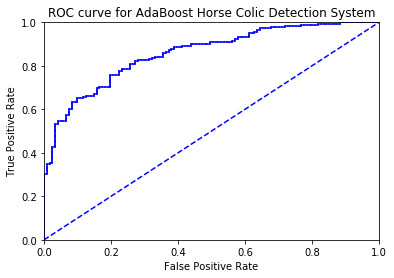

the Area Under the Curve is :  0.8582969635063604


In [44]:
datArr,labelArr = loadDataSet('horseColicTraining2.txt')
classifierArray,aggClassEst = adaBoostTrainDS(datArr,labelArr,10)
plotROC(aggClassEst.T,labelArr)